<a href="https://colab.research.google.com/github/llazdll/Linear_Regression/blob/main/multi_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 🟥 **Imports**

In [315]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
from torch.optim import SGD

In [316]:
from sklearn import datasets

In [317]:

torch.version.__version__

'2.9.0+cpu'

## 🟥 **Step 1: Data**

In [318]:
iris = datasets.load_iris()
X = iris.data
y = iris.target
num_samples, num_features = X.shape
num_classes = len(np.unique(y))
num_samples, num_features, num_classes

(150, 4, 3)

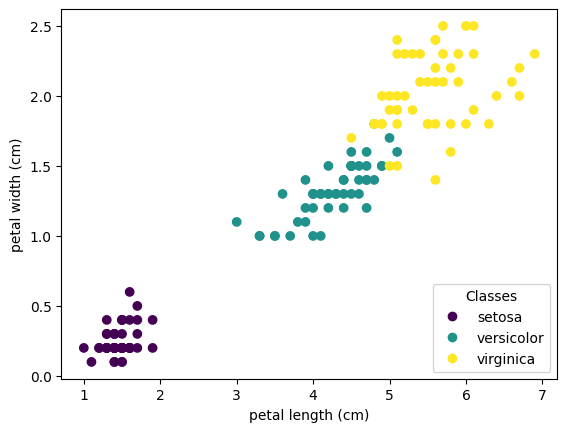

In [319]:
_, ax = plt.subplots()
scatter = ax.scatter(iris.data[:, 2], iris.data[:, 3], c=iris.target)
ax.set(xlabel=iris.feature_names[2], ylabel=iris.feature_names[3])
_ = ax.legend(
    scatter.legend_elements()[0], iris.target_names, loc="lower right", title="Classes"
)

In [320]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=10, stratify=y)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, train_size=0.9, random_state=10, stratify=y_train)
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_test.shape, y_test.shape

((108, 4), (108,), (12, 4), (12,), (30, 4), (30,))

In [321]:
x_scaler = StandardScaler()
X_train = x_scaler.fit_transform(X_train)
X_valid = x_scaler.transform(X_valid)
X_test = x_scaler.transform(X_test)

In [322]:
X_train=torch.tensor(X_train,dtype=torch.float32)
X_valid=torch.tensor(X_valid,dtype=torch.float32)
X_test=torch.tensor(X_test,dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.int64)
y_valid=torch.tensor(y_valid, dtype=torch.int64)
y_test = torch.tensor(y_test, dtype=torch.int64)
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_test.shape, y_test.shape

(torch.Size([108, 4]),
 torch.Size([108]),
 torch.Size([12, 4]),
 torch.Size([12]),
 torch.Size([30, 4]),
 torch.Size([30]))

In [323]:
train_set=TensorDataset(X_train,y_train)
valid_set=TensorDataset(X_valid,y_valid)
test_set=TensorDataset(X_test,y_test)

In [324]:
train_loader = DataLoader(train_set, batch_size=10, shuffle=True)
valid_loader=DataLoader(valid_set, batch_size=10)
test_loader=DataLoader(test_set, batch_size=10)

In [325]:
x_batch, y_batch = next(iter(train_loader))
x_batch.shape, y_batch.shape

(torch.Size([10, 4]), torch.Size([10]))

## 🟥 **Step 2: Model**

In [326]:
model = nn.Sequential(
    nn.Linear(num_features, num_classes),
    nn.Softmax(dim=1)
    )
model

Sequential(
  (0): Linear(in_features=4, out_features=3, bias=True)
  (1): Softmax(dim=1)
)

In [327]:
y_hat=model(X_train)
y_hat.shape

torch.Size([108, 3])

## 🟥 **Step 3: Loss**

In [328]:
loss_fn = nn.CrossEntropyLoss()
loss_fn

CrossEntropyLoss()

## 🟥 **Step 4: Optimizer**

In [329]:
optimizer=SGD(model.parameters(),lr=0.25,momentum=0.85)
optimizer

SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.25
    maximize: False
    momentum: 0.85
    nesterov: False
    weight_decay: 0
)

## 🟥 **Step 5: Train**

In [330]:
y_hat.argmax(dim=1), y_batch

(tensor([1, 1, 1, 2, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1,
         1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1,
         1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 2, 0, 0, 0,
         1, 1, 0, 0, 1, 1, 1, 2, 0, 0, 1, 1]),
 tensor([1, 0, 2, 2, 2, 1, 2, 0, 0, 0]))

In [331]:
n_epochs = 10
loss_train_hist, loss_valid_hist = [], []
acc_train_hist, acc_valid_hist = [], []
best_loss_valid = 10000

In [332]:
for epoch in range(n_epochs):

  mean_loss_train, mean_loss_valid = 0, 0
  mean_acc_train, mean_acc_valid = 0, 0

  for x_batch, y_batch in train_loader:

    # model
    y_hat = model(x_batch)

    # loss
    loss = loss_fn(y_hat, y_batch)

    # gradient
    loss.backward()

    # update
    optimizer.step()
    optimizer.zero_grad()

    mean_loss_train += loss.item() * len(x_batch)
    mean_acc_train += torch.sum(y_hat.argmax(dim=1) == y_batch).item()

  mean_loss_train = mean_loss_train / len(train_set)
  mean_acc_train = mean_acc_train / len(train_set)

  loss_train_hist.append(mean_loss_train)
  acc_train_hist.append(mean_acc_train)


  with torch.no_grad():
    for x_batch, y_batch in valid_loader:
      y_hat = model(x_batch)
      loss = loss_fn(y_hat, y_batch)
      mean_loss_valid += loss.item() * len(x_batch)
      mean_acc_valid += torch.sum(y_hat.argmax(dim=1) == y_batch).item()

    mean_loss_valid = mean_loss_valid / len(valid_set)
    mean_acc_valid = mean_acc_valid / len(valid_set)

    loss_valid_hist.append(mean_loss_valid)
    acc_valid_hist.append(mean_acc_valid)

  print(
  f"Epoch: {epoch}   "
  f"LossTrain: {mean_loss_train:.2}   "
  f"AccTrain: {mean_acc_train:.2}   "
  f"LossValid: {mean_loss_valid:.2}   "
  f"AccValid: {mean_acc_valid:.2}"
  )

  if mean_loss_valid < best_loss_valid:
    torch.save(model, "best-model.pt")
    best_loss_valid = mean_loss_valid
    print("Model Saved!")
    print()

Epoch: 0   LossTrain: 0.86   AccTrain: 0.74   LossValid: 0.71   AccValid: 0.92
Model Saved!

Epoch: 1   LossTrain: 0.75   AccTrain: 0.81   LossValid: 0.67   AccValid: 0.92
Model Saved!

Epoch: 2   LossTrain: 0.71   AccTrain: 0.88   LossValid: 0.65   AccValid: 0.92
Model Saved!

Epoch: 3   LossTrain: 0.7   AccTrain: 0.91   LossValid: 0.64   AccValid: 0.92
Model Saved!

Epoch: 4   LossTrain: 0.67   AccTrain: 0.93   LossValid: 0.65   AccValid: 0.92
Epoch: 5   LossTrain: 0.66   AccTrain: 0.94   LossValid: 0.64   AccValid: 1.0
Epoch: 6   LossTrain: 0.65   AccTrain: 0.96   LossValid: 0.64   AccValid: 1.0
Epoch: 7   LossTrain: 0.64   AccTrain: 0.96   LossValid: 0.62   AccValid: 1.0
Model Saved!

Epoch: 8   LossTrain: 0.64   AccTrain: 0.96   LossValid: 0.63   AccValid: 1.0
Epoch: 9   LossTrain: 0.63   AccTrain: 0.94   LossValid: 0.62   AccValid: 1.0
Model Saved!



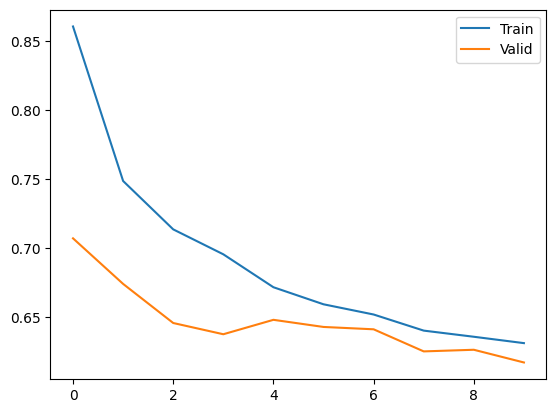

In [333]:
plt.plot(torch.arange(n_epochs), loss_train_hist)
plt.plot(torch.arange(n_epochs), loss_valid_hist)
plt.legend(["Train", "Valid"]);

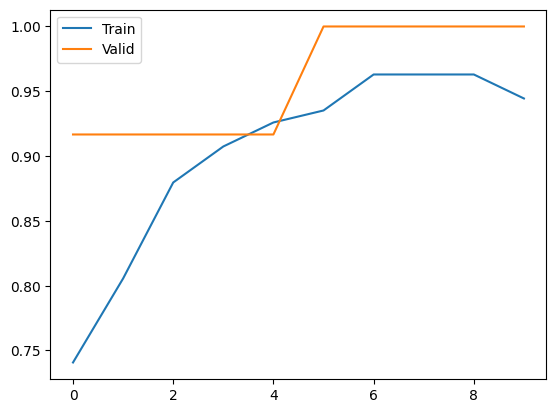

In [334]:
plt.plot(torch.arange(n_epochs), acc_train_hist)
plt.plot(torch.arange(n_epochs), acc_valid_hist)
plt.legend(["Train", "Valid"]);

## 🟥 **Test**

In [336]:
model = torch.load("best-model.pt", weights_only=False)

In [337]:
mean_acc_test = 0

with torch.no_grad():
  for x_batch, y_batch in test_loader:
    y_hat = model(x_batch)
    mean_acc_test += torch.sum(y_hat.argmax(dim=1) == y_batch).item()
  mean_acc_test = mean_acc_test / len(test_set)

mean_acc_test

1.0